 - 텐서플로도 모델을 저장할 수 있다.
 - training_test_split하고 나서 모델을 잘 만들고, 다시 모델을 전체 데이터로 학습시켜야 한다. 이거 까먹으면 안 된다.
 - 앙상블은 항상 써줘야 한다.
 
# Transfer learning with a pretrained ConvNet

https://www.tensorflow.org/tutorials/images/transfer_learning

대부분 이미지넷 데이터가 성능이 아주 좋다. 레스넷은 오차율이 3% 밖에 안 되서, 이미 사람의 영역을 뛰어넘었다.

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for our dataset. You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained.

2. Fine-Tuning: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task. 파인튜닝을 한다고 하면, 케라스 어플리케이션 가져온다는 것이다. 텐서허브는 현재로서는 파인 튜닝하기 어렵다.

 - freeze 개념: train을 안시키는 것이다.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras # 반드시 이런 테크닉 통해서 텐서플로와 케라스 버전 일치시켜야 한다.

In [3]:
import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

### tensorflow dataset

이것은 텐서플로에서만 가능하지, 파이토치같은데서는 가능하지 않다.

In [4]:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eurosat',
 'fashion_mnist',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'image_label_folder',
 'imagenet2012',
 'imagenet2012_corrupted',
 'imagenet_resized',
 'i

In [4]:
dir(tfds.Split.TRAIN.subsplit(weighted = (8, 1, 1)))
# tfds.Split.TEST.subsplit()

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

In [6]:
dataset = tfds.load(name="cats_vs_dogs", split = list())

텐서플로 데이터셋은 다 데이터를 줘버린다.

In [7]:
dataset

[]

In [8]:
from sklearn.model_selection import train_test_split # 이건 밸리데이션까지 쪼개지는 못한다.

# train_test_split()

In [9]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

In [10]:
dir(metadata)
metadata.features # 이것이 x값이다.

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [11]:
metadata.description

'A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.'

In [12]:
print(metadata.citation)
# 나중에 혼자서 공부하면 논문을 공부해야 한다.
# 인용포맷이라는게 있다. 아래처럼. 

@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
year = {2007},
month = {October},
publisher = {Association for Computing Machinery, Inc.},
url = {https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/},
edition = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
}



In [13]:
dir(metadata.features['label'])
metadata.features['label'].int2str(int_value = 0) # 이렇게 숫자로 관리된다. ★★★

'cat'

In [14]:
metadata.features['label'].int2str # bound라고 나오면, 어디어디 결합된다는 것이다. 메소드종류.

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

바운드 객체는 뭔가와 결합된다는 뜻이다. 괄호같은거 써보면 된다.

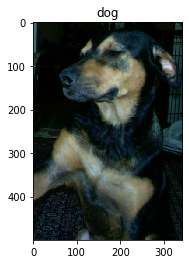

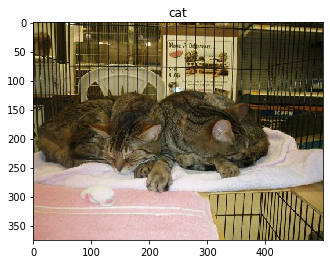

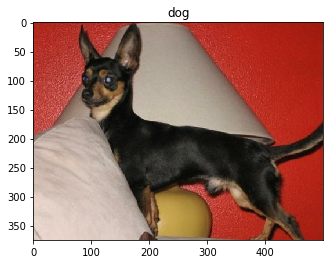

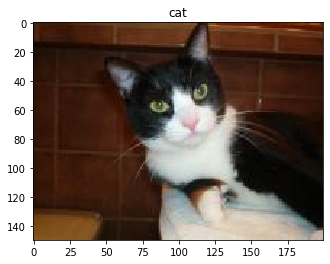

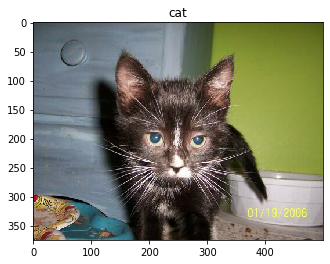

In [15]:
get_label_name = metadata.features['label'].int2str # 일종의 함수 할당

for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

### Format the Data

 - tf.cast: 타입 형태를 변환시키는 것이다. 에러처리까지 된다. astype은 에러처리 안된다. 포맷을 바꿔주는데 에러처리까지 해주는 것이다.
 - -1 ~ 1 사이로 스케일링 해줬다. 이렇게 해주는게 성능이 더 좋았다고 한다. 그런데 이 모델 만든 곳에서 이렇게 똑같이 전처리 해줘야 한다.

In [16]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1 # -1 ~ 1 사이로 스케일링 해준다. 하이퍼볼릭 탄젠트 방식.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [17]:
# dir(tf.data.Dataset)

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [17]:
train

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>

In [18]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [19]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [20]:
for image_batch, label_batch in train_batches.take(1):
     pass # 1개 보기 우해서, 이런 테크닉을 쓰는 것이다.

image_batch.shape

TensorShape([32, 160, 160, 3])

### Create the base model from the pre-trained convnets

In [21]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model_head = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 45s - ETA: 35 - ETA: 36 - ETA: 32 - ETA: 21 - ETA: 21 - ETA: 12 - ETA: 12 - ETA: 6 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 0us/step


In [22]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [27]:
base_model.trainable = False # 이게 바로 freeze이다.
base_model_head.trainable = False

In [28]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, 10, 10, 64)   24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, 10, 10, 64)   256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, 10, 10, 64)   0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, 10, 10, 384)  24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

맨 밑에 trainable_param 있는데, 학습될 수 있는 파라미터가 없다는 뜻이다. trainable = False로 했기 때문.

★★★★★
 - 2개 분류: sigmoid
 - 멀티 분류: softmax

In [43]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 32001     
Total params: 2,289,985
Trainable params: 32,001
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = tf.losses.binary_crossentropy,
              metrics = ['accuracy'])

### Train the model

In [46]:
history = model.fit_generator(train_batches,
                    epochs = 5)

Epoch 1/5


    167/Unknown - 1s 1s/step - loss: 0.7907 - accuracy: 0.62 - 1s 743ms/step - loss: 1.2824 - accuracy: 0.625 - 2s 567ms/step - loss: 1.4996 - accuracy: 0.552 - 2s 479ms/step - loss: 1.1956 - accuracy: 0.640 - 2s 425ms/step - loss: 1.3517 - accuracy: 0.612 - 2s 390ms/step - loss: 1.3816 - accuracy: 0.614 - 3s 365ms/step - loss: 1.3383 - accuracy: 0.629 - 3s 346ms/step - loss: 1.2332 - accuracy: 0.664 - 3s 331ms/step - loss: 1.1024 - accuracy: 0.701 - 3s 322ms/step - loss: 1.0585 - accuracy: 0.712 - 3s 312ms/step - loss: 0.9977 - accuracy: 0.730 - 4s 305ms/step - loss: 1.0137 - accuracy: 0.731 - 4s 298ms/step - loss: 0.9596 - accuracy: 0.745 - 4s 294ms/step - loss: 0.9321 - accuracy: 0.754 - 4s 288ms/step - loss: 0.8809 - accuracy: 0.764 - 5s 284ms/step - loss: 0.8264 - accuracy: 0.779 - 5s 280ms/step - loss: 0.7969 - accuracy: 0.786 - 5s 277ms/step - loss: 0.7699 - accuracy: 0.793 - 5s 274ms/step - loss: 0.7365 - accuracy: 0.802 - 5s 271ms/step - loss: 0.7196 - accuracy: 0.806 - 6s 268

    500/Unknown - 74s 220ms/step - loss: 0.3013 - accuracy: 0.92 - 74s 220ms/step - loss: 0.3008 - accuracy: 0.92 - 74s 220ms/step - loss: 0.3008 - accuracy: 0.92 - 74s 220ms/step - loss: 0.3017 - accuracy: 0.92 - 75s 220ms/step - loss: 0.3027 - accuracy: 0.92 - 75s 220ms/step - loss: 0.3018 - accuracy: 0.92 - 75s 220ms/step - loss: 0.3012 - accuracy: 0.92 - 75s 220ms/step - loss: 0.3013 - accuracy: 0.92 - 75s 220ms/step - loss: 0.3023 - accuracy: 0.92 - 76s 220ms/step - loss: 0.3014 - accuracy: 0.92 - 76s 220ms/step - loss: 0.3011 - accuracy: 0.92 - 76s 220ms/step - loss: 0.3003 - accuracy: 0.92 - 76s 220ms/step - loss: 0.3001 - accuracy: 0.92 - 76s 220ms/step - loss: 0.3002 - accuracy: 0.92 - 77s 220ms/step - loss: 0.2993 - accuracy: 0.92 - 77s 220ms/step - loss: 0.2985 - accuracy: 0.93 - 77s 220ms/step - loss: 0.3013 - accuracy: 0.92 - 77s 220ms/step - loss: 0.3004 - accuracy: 0.93 - 78s 220ms/step - loss: 0.2999 - accuracy: 0.93 - 78s 220ms/step - loss: 0.2992 - accuracy: 0.93 - 78

582/582 [==============================]: 0.3105 - accuracy: 0.931 - 110s 218ms/step - loss: 0.3099 - accuracy: 0.931 - 110s 218ms/step - loss: 0.3095 - accuracy: 0.931 - 110s 218ms/step - loss: 0.3096 - accuracy: 0.931 - 110s 218ms/step - loss: 0.3091 - accuracy: 0.931 - 110s 218ms/step - loss: 0.3093 - accuracy: 0.931 - 111s 218ms/step - loss: 0.3089 - accuracy: 0.932 - 111s 218ms/step - loss: 0.3083 - accuracy: 0.932 - 111s 218ms/step - loss: 0.3081 - accuracy: 0.932 - 111s 218ms/step - loss: 0.3081 - accuracy: 0.932 - 112s 218ms/step - loss: 0.3084 - accuracy: 0.932 - 112s 218ms/step - loss: 0.3091 - accuracy: 0.932 - 112s 218ms/step - loss: 0.3087 - accuracy: 0.932 - 112s 218ms/step - loss: 0.3088 - accuracy: 0.932 - 112s 218ms/step - loss: 0.3093 - accuracy: 0.932 - 113s 218ms/step - loss: 0.3098 - accuracy: 0.932 - 113s 218ms/step - loss: 0.3098 - accuracy: 0.932 - 113s 218ms/step - loss: 0.3100 - accuracy: 0.932 - 113s 218ms/step - loss: 0.3107 - accuracy: 0.932 - 114s 218ms/st

186/582 [========>.....................] - ETA: 12:12 - loss: 0.4160 - accuracy: 0.968 - ETA: 7:08 - loss: 0.3283 - accuracy: 0.953 - ETA: 5:25 - loss: 0.2266 - accuracy: 0.96 - ETA: 4:35 - loss: 0.2795 - accuracy: 0.95 - ETA: 4:05 - loss: 0.2354 - accuracy: 0.95 - ETA: 3:44 - loss: 0.2373 - accuracy: 0.95 - ETA: 3:30 - loss: 0.2035 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1867 - accuracy: 0.96 - ETA: 3:10 - loss: 0.1686 - accuracy: 0.96 - ETA: 3:03 - loss: 0.1598 - accuracy: 0.96 - ETA: 2:57 - loss: 0.1537 - accuracy: 0.96 - ETA: 2:53 - loss: 0.1409 - accuracy: 0.96 - ETA: 2:49 - loss: 0.1303 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1392 - accuracy: 0.96 - ETA: 2:42 - loss: 0.1544 - accuracy: 0.96 - ETA: 2:40 - loss: 0.1453 - accuracy: 0.96 - ETA: 2:38 - loss: 0.1484 - accuracy: 0.96 - ETA: 2:35 - loss: 0.1548 - accuracy: 0.96 - ETA: 2:34 - loss: 0.1479 - accuracy: 0.96 - ETA: 2:32 - loss: 0.1456 - accuracy: 0.96 - ETA: 2:31 - loss: 0.1696 - accuracy: 0.96 - ETA: 2:29 - loss: 0.1748 - acc

559/582 [===========================>..] - ETA: 46s - loss: 0.2144 - accuracy: 0.958 - ETA: 46s - loss: 0.2157 - accuracy: 0.958 - ETA: 45s - loss: 0.2151 - accuracy: 0.958 - ETA: 45s - loss: 0.2157 - accuracy: 0.958 - ETA: 45s - loss: 0.2151 - accuracy: 0.958 - ETA: 45s - loss: 0.2146 - accuracy: 0.958 - ETA: 44s - loss: 0.2141 - accuracy: 0.958 - ETA: 44s - loss: 0.2135 - accuracy: 0.958 - ETA: 44s - loss: 0.2130 - accuracy: 0.958 - ETA: 44s - loss: 0.2125 - accuracy: 0.958 - ETA: 44s - loss: 0.2120 - accuracy: 0.959 - ETA: 43s - loss: 0.2115 - accuracy: 0.959 - ETA: 43s - loss: 0.2110 - accuracy: 0.959 - ETA: 43s - loss: 0.2121 - accuracy: 0.959 - ETA: 43s - loss: 0.2122 - accuracy: 0.959 - ETA: 42s - loss: 0.2125 - accuracy: 0.958 - ETA: 42s - loss: 0.2132 - accuracy: 0.958 - ETA: 42s - loss: 0.2128 - accuracy: 0.958 - ETA: 42s - loss: 0.2123 - accuracy: 0.958 - ETA: 42s - loss: 0.2126 - accuracy: 0.958 - ETA: 41s - loss: 0.2135 - accuracy: 0.958 - ETA: 41s - loss: 0.2154 - accurac

582/582 [==============================] - ETA: 4s - loss: 0.2201 - accuracy: 0.95 - ETA: 4s - loss: 0.2197 - accuracy: 0.95 - ETA: 4s - loss: 0.2194 - accuracy: 0.95 - ETA: 4s - loss: 0.2190 - accuracy: 0.95 - ETA: 3s - loss: 0.2190 - accuracy: 0.95 - ETA: 3s - loss: 0.2186 - accuracy: 0.95 - ETA: 3s - loss: 0.2182 - accuracy: 0.95 - ETA: 3s - loss: 0.2178 - accuracy: 0.95 - ETA: 3s - loss: 0.2185 - accuracy: 0.95 - ETA: 2s - loss: 0.2185 - accuracy: 0.95 - ETA: 2s - loss: 0.2185 - accuracy: 0.95 - ETA: 2s - loss: 0.2182 - accuracy: 0.95 - ETA: 2s - loss: 0.2178 - accuracy: 0.95 - ETA: 1s - loss: 0.2174 - accuracy: 0.95 - ETA: 1s - loss: 0.2170 - accuracy: 0.95 - ETA: 1s - loss: 0.2167 - accuracy: 0.95 - ETA: 1s - loss: 0.2169 - accuracy: 0.95 - ETA: 1s - loss: 0.2174 - accuracy: 0.95 - ETA: 0s - loss: 0.2170 - accuracy: 0.95 - ETA: 0s - loss: 0.2166 - accuracy: 0.95 - ETA: 0s - loss: 0.2163 - accuracy: 0.95 - ETA: 0s - loss: 0.2159 - accuracy: 0.95 - 127s 218ms/step - loss: 0.2156 - 

186/582 [========>.....................] - ETA: 11:54 - loss: 0.0049 - accuracy: 1.000 - ETA: 7:00 - loss: 0.0028 - accuracy: 1.000 - ETA: 5:20 - loss: 0.0019 - accuracy: 1.00 - ETA: 4:30 - loss: 0.0957 - accuracy: 0.98 - ETA: 4:00 - loss: 0.1516 - accuracy: 0.97 - ETA: 3:43 - loss: 0.1270 - accuracy: 0.97 - ETA: 3:28 - loss: 0.1089 - accuracy: 0.98 - ETA: 3:17 - loss: 0.1462 - accuracy: 0.97 - ETA: 3:08 - loss: 0.1565 - accuracy: 0.97 - ETA: 3:02 - loss: 0.1516 - accuracy: 0.97 - ETA: 2:56 - loss: 0.1612 - accuracy: 0.97 - ETA: 2:51 - loss: 0.1480 - accuracy: 0.97 - ETA: 2:47 - loss: 0.1366 - accuracy: 0.97 - ETA: 2:43 - loss: 0.1272 - accuracy: 0.97 - ETA: 2:40 - loss: 0.1326 - accuracy: 0.97 - ETA: 2:38 - loss: 0.1244 - accuracy: 0.97 - ETA: 2:35 - loss: 0.1172 - accuracy: 0.97 - ETA: 2:33 - loss: 0.1125 - accuracy: 0.97 - ETA: 2:31 - loss: 0.1066 - accuracy: 0.97 - ETA: 2:29 - loss: 0.1016 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0998 - accuracy: 0.97 - ETA: 2:26 - loss: 0.0998 - acc

559/582 [===========================>..] - ETA: 45s - loss: 0.1912 - accuracy: 0.965 - ETA: 44s - loss: 0.1907 - accuracy: 0.965 - ETA: 44s - loss: 0.1908 - accuracy: 0.965 - ETA: 44s - loss: 0.1906 - accuracy: 0.965 - ETA: 44s - loss: 0.1908 - accuracy: 0.965 - ETA: 43s - loss: 0.1914 - accuracy: 0.965 - ETA: 43s - loss: 0.1917 - accuracy: 0.965 - ETA: 43s - loss: 0.1912 - accuracy: 0.965 - ETA: 43s - loss: 0.1907 - accuracy: 0.965 - ETA: 43s - loss: 0.1902 - accuracy: 0.965 - ETA: 42s - loss: 0.1905 - accuracy: 0.965 - ETA: 42s - loss: 0.1900 - accuracy: 0.965 - ETA: 42s - loss: 0.1896 - accuracy: 0.965 - ETA: 42s - loss: 0.1891 - accuracy: 0.965 - ETA: 42s - loss: 0.1886 - accuracy: 0.965 - ETA: 41s - loss: 0.1882 - accuracy: 0.965 - ETA: 41s - loss: 0.1883 - accuracy: 0.965 - ETA: 41s - loss: 0.1895 - accuracy: 0.965 - ETA: 41s - loss: 0.1890 - accuracy: 0.965 - ETA: 40s - loss: 0.1886 - accuracy: 0.965 - ETA: 40s - loss: 0.1881 - accuracy: 0.966 - ETA: 40s - loss: 0.1887 - accurac

582/582 [==============================] - ETA: 4s - loss: 0.2016 - accuracy: 0.96 - ETA: 4s - loss: 0.2016 - accuracy: 0.96 - ETA: 4s - loss: 0.2024 - accuracy: 0.96 - ETA: 4s - loss: 0.2020 - accuracy: 0.96 - ETA: 3s - loss: 0.2017 - accuracy: 0.96 - ETA: 3s - loss: 0.2017 - accuracy: 0.96 - ETA: 3s - loss: 0.2033 - accuracy: 0.96 - ETA: 3s - loss: 0.2030 - accuracy: 0.96 - ETA: 3s - loss: 0.2035 - accuracy: 0.96 - ETA: 2s - loss: 0.2031 - accuracy: 0.96 - ETA: 2s - loss: 0.2048 - accuracy: 0.96 - ETA: 2s - loss: 0.2045 - accuracy: 0.96 - ETA: 2s - loss: 0.2044 - accuracy: 0.96 - ETA: 1s - loss: 0.2049 - accuracy: 0.96 - ETA: 1s - loss: 0.2048 - accuracy: 0.96 - ETA: 1s - loss: 0.2045 - accuracy: 0.96 - ETA: 1s - loss: 0.2041 - accuracy: 0.96 - ETA: 1s - loss: 0.2044 - accuracy: 0.96 - ETA: 0s - loss: 0.2049 - accuracy: 0.96 - ETA: 0s - loss: 0.2051 - accuracy: 0.96 - ETA: 0s - loss: 0.2048 - accuracy: 0.96 - ETA: 0s - loss: 0.2045 - accuracy: 0.96 - 125s 214ms/step - loss: 0.2046 - 

186/582 [========>.....................] - ETA: 11:54 - loss: 0.1648 - accuracy: 0.906 - ETA: 7:00 - loss: 0.2401 - accuracy: 0.937 - ETA: 5:21 - loss: 0.2494 - accuracy: 0.93 - ETA: 4:30 - loss: 0.1981 - accuracy: 0.93 - ETA: 4:00 - loss: 0.1587 - accuracy: 0.95 - ETA: 3:40 - loss: 0.1323 - accuracy: 0.95 - ETA: 3:25 - loss: 0.1332 - accuracy: 0.95 - ETA: 3:14 - loss: 0.1166 - accuracy: 0.96 - ETA: 3:05 - loss: 0.1900 - accuracy: 0.95 - ETA: 2:58 - loss: 0.1715 - accuracy: 0.95 - ETA: 2:53 - loss: 0.1559 - accuracy: 0.96 - ETA: 2:49 - loss: 0.1429 - accuracy: 0.96 - ETA: 2:45 - loss: 0.1322 - accuracy: 0.96 - ETA: 2:42 - loss: 0.1438 - accuracy: 0.96 - ETA: 2:39 - loss: 0.1359 - accuracy: 0.97 - ETA: 2:36 - loss: 0.1287 - accuracy: 0.97 - ETA: 2:34 - loss: 0.1223 - accuracy: 0.97 - ETA: 2:31 - loss: 0.1183 - accuracy: 0.97 - ETA: 2:30 - loss: 0.1134 - accuracy: 0.97 - ETA: 2:28 - loss: 0.1077 - accuracy: 0.97 - ETA: 2:26 - loss: 0.1027 - accuracy: 0.97 - ETA: 2:24 - loss: 0.1150 - acc

559/582 [===========================>..] - ETA: 45s - loss: 0.1643 - accuracy: 0.972 - ETA: 44s - loss: 0.1638 - accuracy: 0.972 - ETA: 44s - loss: 0.1634 - accuracy: 0.972 - ETA: 44s - loss: 0.1654 - accuracy: 0.972 - ETA: 44s - loss: 0.1649 - accuracy: 0.972 - ETA: 44s - loss: 0.1645 - accuracy: 0.972 - ETA: 43s - loss: 0.1642 - accuracy: 0.972 - ETA: 43s - loss: 0.1643 - accuracy: 0.972 - ETA: 43s - loss: 0.1645 - accuracy: 0.972 - ETA: 43s - loss: 0.1641 - accuracy: 0.972 - ETA: 42s - loss: 0.1638 - accuracy: 0.972 - ETA: 42s - loss: 0.1638 - accuracy: 0.972 - ETA: 42s - loss: 0.1645 - accuracy: 0.972 - ETA: 42s - loss: 0.1641 - accuracy: 0.972 - ETA: 42s - loss: 0.1651 - accuracy: 0.972 - ETA: 41s - loss: 0.1647 - accuracy: 0.972 - ETA: 41s - loss: 0.1655 - accuracy: 0.972 - ETA: 41s - loss: 0.1659 - accuracy: 0.972 - ETA: 41s - loss: 0.1656 - accuracy: 0.972 - ETA: 41s - loss: 0.1664 - accuracy: 0.972 - ETA: 40s - loss: 0.1672 - accuracy: 0.971 - ETA: 40s - loss: 0.1668 - accurac

582/582 [==============================] - ETA: 4s - loss: 0.1799 - accuracy: 0.97 - ETA: 4s - loss: 0.1796 - accuracy: 0.97 - ETA: 4s - loss: 0.1792 - accuracy: 0.97 - ETA: 4s - loss: 0.1794 - accuracy: 0.97 - ETA: 3s - loss: 0.1797 - accuracy: 0.97 - ETA: 3s - loss: 0.1804 - accuracy: 0.97 - ETA: 3s - loss: 0.1802 - accuracy: 0.97 - ETA: 3s - loss: 0.1799 - accuracy: 0.97 - ETA: 3s - loss: 0.1814 - accuracy: 0.97 - ETA: 2s - loss: 0.1812 - accuracy: 0.97 - ETA: 2s - loss: 0.1808 - accuracy: 0.97 - ETA: 2s - loss: 0.1805 - accuracy: 0.97 - ETA: 2s - loss: 0.1809 - accuracy: 0.97 - ETA: 1s - loss: 0.1812 - accuracy: 0.97 - ETA: 1s - loss: 0.1811 - accuracy: 0.97 - ETA: 1s - loss: 0.1816 - accuracy: 0.97 - ETA: 1s - loss: 0.1814 - accuracy: 0.97 - ETA: 1s - loss: 0.1810 - accuracy: 0.97 - ETA: 0s - loss: 0.1828 - accuracy: 0.97 - ETA: 0s - loss: 0.1825 - accuracy: 0.97 - ETA: 0s - loss: 0.1822 - accuracy: 0.97 - ETA: 0s - loss: 0.1820 - accuracy: 0.97 - 125s 214ms/step - loss: 0.1817 - 

186/582 [========>.....................] - ETA: 11:43 - loss: 0.2381 - accuracy: 0.937 - ETA: 6:54 - loss: 0.2834 - accuracy: 0.953 - ETA: 5:16 - loss: 0.2715 - accuracy: 0.94 - ETA: 4:26 - loss: 0.2038 - accuracy: 0.96 - ETA: 3:57 - loss: 0.2092 - accuracy: 0.95 - ETA: 3:39 - loss: 0.1743 - accuracy: 0.96 - ETA: 3:26 - loss: 0.2256 - accuracy: 0.95 - ETA: 3:15 - loss: 0.1974 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1755 - accuracy: 0.96 - ETA: 3:00 - loss: 0.1593 - accuracy: 0.97 - ETA: 2:54 - loss: 0.1460 - accuracy: 0.97 - ETA: 2:49 - loss: 0.1492 - accuracy: 0.97 - ETA: 2:45 - loss: 0.1505 - accuracy: 0.96 - ETA: 2:42 - loss: 0.1398 - accuracy: 0.97 - ETA: 2:39 - loss: 0.1306 - accuracy: 0.97 - ETA: 2:36 - loss: 0.1405 - accuracy: 0.97 - ETA: 2:34 - loss: 0.1429 - accuracy: 0.97 - ETA: 2:32 - loss: 0.1349 - accuracy: 0.97 - ETA: 2:30 - loss: 0.1419 - accuracy: 0.97 - ETA: 2:28 - loss: 0.1378 - accuracy: 0.97 - ETA: 2:27 - loss: 0.1313 - accuracy: 0.97 - ETA: 2:25 - loss: 0.1365 - acc

559/582 [===========================>..] - ETA: 45s - loss: 0.1555 - accuracy: 0.975 - ETA: 45s - loss: 0.1582 - accuracy: 0.974 - ETA: 45s - loss: 0.1582 - accuracy: 0.974 - ETA: 44s - loss: 0.1578 - accuracy: 0.974 - ETA: 44s - loss: 0.1574 - accuracy: 0.975 - ETA: 44s - loss: 0.1593 - accuracy: 0.974 - ETA: 44s - loss: 0.1618 - accuracy: 0.974 - ETA: 43s - loss: 0.1618 - accuracy: 0.974 - ETA: 43s - loss: 0.1620 - accuracy: 0.974 - ETA: 43s - loss: 0.1616 - accuracy: 0.974 - ETA: 43s - loss: 0.1612 - accuracy: 0.974 - ETA: 43s - loss: 0.1625 - accuracy: 0.974 - ETA: 42s - loss: 0.1624 - accuracy: 0.974 - ETA: 42s - loss: 0.1631 - accuracy: 0.974 - ETA: 42s - loss: 0.1628 - accuracy: 0.974 - ETA: 42s - loss: 0.1637 - accuracy: 0.974 - ETA: 41s - loss: 0.1643 - accuracy: 0.974 - ETA: 41s - loss: 0.1658 - accuracy: 0.974 - ETA: 41s - loss: 0.1665 - accuracy: 0.974 - ETA: 41s - loss: 0.1667 - accuracy: 0.974 - ETA: 41s - loss: 0.1666 - accuracy: 0.974 - ETA: 40s - loss: 0.1667 - accurac

582/582 [==============================] - ETA: 4s - loss: 0.1779 - accuracy: 0.97 - ETA: 4s - loss: 0.1775 - accuracy: 0.97 - ETA: 4s - loss: 0.1773 - accuracy: 0.97 - ETA: 4s - loss: 0.1776 - accuracy: 0.97 - ETA: 3s - loss: 0.1782 - accuracy: 0.97 - ETA: 3s - loss: 0.1780 - accuracy: 0.97 - ETA: 3s - loss: 0.1776 - accuracy: 0.97 - ETA: 3s - loss: 0.1773 - accuracy: 0.97 - ETA: 3s - loss: 0.1770 - accuracy: 0.97 - ETA: 2s - loss: 0.1767 - accuracy: 0.97 - ETA: 2s - loss: 0.1764 - accuracy: 0.97 - ETA: 2s - loss: 0.1761 - accuracy: 0.97 - ETA: 2s - loss: 0.1758 - accuracy: 0.97 - ETA: 1s - loss: 0.1755 - accuracy: 0.97 - ETA: 1s - loss: 0.1752 - accuracy: 0.97 - ETA: 1s - loss: 0.1750 - accuracy: 0.97 - ETA: 1s - loss: 0.1752 - accuracy: 0.97 - ETA: 1s - loss: 0.1749 - accuracy: 0.97 - ETA: 0s - loss: 0.1749 - accuracy: 0.97 - ETA: 0s - loss: 0.1761 - accuracy: 0.97 - ETA: 0s - loss: 0.1783 - accuracy: 0.97 - ETA: 0s - loss: 0.1788 - accuracy: 0.97 - 126s 216ms/step - loss: 0.1785 - 

In [47]:
history.history

{'loss': [0.31776693805153755,
  0.2155844528542808,
  0.2045484134010246,
  0.18167758996902675,
  0.17850223989206718],
 'accuracy': [0.9323918, 0.95983243, 0.96584684, 0.97019655, 0.9730963]}

In [76]:
model.evaluate(test_batches)

73/73 [==============================].0799 - accuracy: 0.96 - 1s 671ms/step - loss: 0.8368 - accuracy: 0.937 - 1s 458ms/step - loss: 1.0296 - accuracy: 0.927 - 1s 352ms/step - loss: 0.7722 - accuracy: 0.945 - 1s 290ms/step - loss: 0.6367 - accuracy: 0.950 - 1s 249ms/step - loss: 0.7222 - accuracy: 0.947 - 2s 218ms/step - loss: 0.9748 - accuracy: 0.942 - 2s 194ms/step - loss: 0.8529 - accuracy: 0.949 - 2s 176ms/step - loss: 0.7841 - accuracy: 0.947 - 2s 162ms/step - loss: 0.7241 - accuracy: 0.950 - 2s 151ms/step - loss: 0.7009 - accuracy: 0.948 - 2s 142ms/step - loss: 0.7081 - accuracy: 0.950 - 2s 133ms/step - loss: 0.6540 - accuracy: 0.954 - 2s 126ms/step - loss: 0.6706 - accuracy: 0.953 - 2s 120ms/step - loss: 0.6307 - accuracy: 0.954 - 2s 114ms/step - loss: 0.5943 - accuracy: 0.955 - 2s 109ms/step - loss: 0.6053 - accuracy: 0.950 - 2s 106ms/step - loss: 0.5886 - accuracy: 0.951 - 2s 102ms/step - loss: 0.5809 - accuracy: 0.949 - 2s 99ms/step - loss: 0.6104 - accuracy: 0.948 - 2s 95ms

[0.6023385304737149, 0.95086205]

# Dense를 안집어넣는 기법 (고급)

Dense 2개에서 1개로 줄이면, 학습이 안되야 하는데 성능이 좋다. 그래서 더 고민을 하게 되었다.

중간에 Dense 안넣어도 학습 잘된다. 글로벌 에버리지만 넣어도, 성능이 나오기 때문에 많이 쓰는 기법이다.

★★★ 글로벌 에버리지 기법을 써서 해도 잘 된다. (플래튼 대신) 풀링은 학습시키는게 아니라서 빨리 된다.

사람들이 알아낸 사실

 - 남의 것을 가져와서 Dense 1개만 써도 성능이 괜찮은 경우가 있다.
 - Flatten 대신 Pooling을 쓰면, 좀더 고차원적이고 계산복잡도를 줄일 수 있다.
 - 예측 Dense 대신, Globalpooling을 써도 된다(?)

In [77]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [78]:
model2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation = 'sigmoid')
])

In [79]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [81]:
model2.compile(optimizer = tf.optimizers.Adam(),
               loss = tf.losses.binary_crossentropy,
               metrics = ['accuracy'])

In [85]:
model2.fit(train_batches, epochs = 5)

Epoch 1/5


    168/Unknown - 3s 3s/step - loss: 1.0133 - accuracy: 0.21 - 3s 2s/step - loss: 0.8921 - accuracy: 0.35 - 3s 1s/step - loss: 0.9074 - accuracy: 0.35 - 3s 831ms/step - loss: 0.8974 - accuracy: 0.382 - 3s 679ms/step - loss: 0.8877 - accuracy: 0.400 - 3s 576ms/step - loss: 0.8670 - accuracy: 0.406 - 4s 504ms/step - loss: 0.8504 - accuracy: 0.428 - 4s 449ms/step - loss: 0.8170 - accuracy: 0.460 - 4s 407ms/step - loss: 0.8053 - accuracy: 0.472 - 4s 373ms/step - loss: 0.7985 - accuracy: 0.484 - 4s 345ms/step - loss: 0.7878 - accuracy: 0.494 - 4s 323ms/step - loss: 0.7770 - accuracy: 0.505 - 4s 303ms/step - loss: 0.7622 - accuracy: 0.521 - 4s 286ms/step - loss: 0.7539 - accuracy: 0.529 - 4s 271ms/step - loss: 0.7478 - accuracy: 0.535 - 4s 259ms/step - loss: 0.7399 - accuracy: 0.544 - 4s 247ms/step - loss: 0.7266 - accuracy: 0.557 - 4s 237ms/step - loss: 0.7143 - accuracy: 0.569 - 4s 228ms/step - loss: 0.6992 - accuracy: 0.585 - 4s 220ms/step - loss: 0.6842 - accuracy: 0.596 - 4s 213ms/step 

    502/Unknown - 25s 75ms/step - loss: 0.2267 - accuracy: 0.901 - 25s 75ms/step - loss: 0.2263 - accuracy: 0.901 - 25s 75ms/step - loss: 0.2259 - accuracy: 0.902 - 25s 75ms/step - loss: 0.2258 - accuracy: 0.902 - 25s 75ms/step - loss: 0.2256 - accuracy: 0.902 - 26s 75ms/step - loss: 0.2252 - accuracy: 0.902 - 26s 75ms/step - loss: 0.2248 - accuracy: 0.902 - 26s 75ms/step - loss: 0.2246 - accuracy: 0.902 - 26s 75ms/step - loss: 0.2245 - accuracy: 0.902 - 26s 75ms/step - loss: 0.2241 - accuracy: 0.903 - 26s 75ms/step - loss: 0.2240 - accuracy: 0.903 - 26s 75ms/step - loss: 0.2235 - accuracy: 0.903 - 26s 75ms/step - loss: 0.2232 - accuracy: 0.903 - 26s 75ms/step - loss: 0.2234 - accuracy: 0.903 - 26s 75ms/step - loss: 0.2230 - accuracy: 0.903 - 26s 74ms/step - loss: 0.2227 - accuracy: 0.903 - 26s 74ms/step - loss: 0.2223 - accuracy: 0.903 - 26s 74ms/step - loss: 0.2219 - accuracy: 0.904 - 26s 74ms/step - loss: 0.2218 - accuracy: 0.904 - 26s 74ms/step - loss: 0.2215 - accuracy: 0.904 - 26

582/582 [==============================]0.2016 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2018 - accuracy: 0.913 - 36s 71ms/step - loss: 0.2018 - accuracy: 0.913 - 36s 71ms/step - loss: 0.2016 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2017 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2016 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2014 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2012 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2011 - accuracy: 0.914 - 36s 71ms/step - loss: 0.2010 - accuracy: 0.914 - 37s 71ms/step - loss: 0.2008 - accuracy: 0.914 - 37s 71ms/step - loss: 0.2008 - accuracy: 0.914 - 37s 71ms/step - loss: 0.2006 - accuracy: 0.914 - 37s 71ms/step - loss: 0.2005 - accuracy: 0.914 - 37s 71ms/step - loss: 0.2002 - accuracy: 0.914 - 37s 71ms/step - loss: 0.1999 - accuracy: 0.914 - 37s 71ms/step - loss: 0.1996 - accuracy: 0.915 - 37s 71ms/step - loss: 0.1994 - accuracy: 0.915 - 37s 71ms/step - loss: 0.1992 - accuracy: 0.915 - 37s 71ms/step - loss: 0.1995 - accuracy: 0.915 - 37

186/582 [========>.....................] - ETA: 10:08 - loss: 0.0571 - accuracy: 0.968 - ETA: 5:22 - loss: 0.0677 - accuracy: 0.984 - ETA: 3:46 - loss: 0.0615 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0719 - accuracy: 0.98 - ETA: 2:29 - loss: 0.0966 - accuracy: 0.97 - ETA: 2:10 - loss: 0.0846 - accuracy: 0.97 - ETA: 1:57 - loss: 0.1146 - accuracy: 0.96 - ETA: 1:47 - loss: 0.1080 - accuracy: 0.96 - ETA: 1:38 - loss: 0.1125 - accuracy: 0.96 - ETA: 1:32 - loss: 0.1135 - accuracy: 0.95 - ETA: 1:27 - loss: 0.1131 - accuracy: 0.96 - ETA: 1:22 - loss: 0.1091 - accuracy: 0.96 - ETA: 1:18 - loss: 0.1033 - accuracy: 0.96 - ETA: 1:15 - loss: 0.1025 - accuracy: 0.96 - ETA: 1:13 - loss: 0.1007 - accuracy: 0.96 - ETA: 1:10 - loss: 0.1015 - accuracy: 0.96 - ETA: 1:08 - loss: 0.1056 - accuracy: 0.96 - ETA: 1:06 - loss: 0.1067 - accuracy: 0.96 - ETA: 1:04 - loss: 0.1113 - accuracy: 0.96 - ETA: 1:03 - loss: 0.1126 - accuracy: 0.96 - ETA: 1:01 - loss: 0.1174 - accuracy: 0.95 - ETA: 1:00 - loss: 0.1239 - acc

577/582 [============================>.] - ETA: 13s - loss: 0.1239 - accuracy: 0.952 - ETA: 13s - loss: 0.1246 - accuracy: 0.952 - ETA: 13s - loss: 0.1247 - accuracy: 0.952 - ETA: 13s - loss: 0.1250 - accuracy: 0.952 - ETA: 13s - loss: 0.1252 - accuracy: 0.952 - ETA: 13s - loss: 0.1253 - accuracy: 0.952 - ETA: 13s - loss: 0.1253 - accuracy: 0.952 - ETA: 13s - loss: 0.1251 - accuracy: 0.952 - ETA: 13s - loss: 0.1249 - accuracy: 0.952 - ETA: 13s - loss: 0.1248 - accuracy: 0.952 - ETA: 13s - loss: 0.1246 - accuracy: 0.952 - ETA: 13s - loss: 0.1245 - accuracy: 0.952 - ETA: 12s - loss: 0.1242 - accuracy: 0.952 - ETA: 12s - loss: 0.1241 - accuracy: 0.952 - ETA: 12s - loss: 0.1240 - accuracy: 0.952 - ETA: 12s - loss: 0.1239 - accuracy: 0.952 - ETA: 12s - loss: 0.1238 - accuracy: 0.952 - ETA: 12s - loss: 0.1236 - accuracy: 0.952 - ETA: 12s - loss: 0.1238 - accuracy: 0.952 - ETA: 12s - loss: 0.1237 - accuracy: 0.952 - ETA: 12s - loss: 0.1235 - accuracy: 0.952 - ETA: 12s - loss: 0.1237 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - 37s 64ms/step - loss: 0.1241 - accuracy: 0.9529
Epoch 3/5


186/582 [========>.....................] - ETA: 10:15 - loss: 0.2069 - accuracy: 0.906 - ETA: 5:25 - loss: 0.1555 - accuracy: 0.921 - ETA: 3:48 - loss: 0.1383 - accuracy: 0.92 - ETA: 3:00 - loss: 0.1092 - accuracy: 0.94 - ETA: 2:31 - loss: 0.0941 - accuracy: 0.95 - ETA: 2:13 - loss: 0.0931 - accuracy: 0.95 - ETA: 1:59 - loss: 0.0919 - accuracy: 0.95 - ETA: 1:49 - loss: 0.1169 - accuracy: 0.95 - ETA: 1:40 - loss: 0.1268 - accuracy: 0.94 - ETA: 1:34 - loss: 0.1241 - accuracy: 0.95 - ETA: 1:28 - loss: 0.1202 - accuracy: 0.95 - ETA: 1:24 - loss: 0.1184 - accuracy: 0.95 - ETA: 1:20 - loss: 0.1155 - accuracy: 0.95 - ETA: 1:17 - loss: 0.1161 - accuracy: 0.95 - ETA: 1:14 - loss: 0.1140 - accuracy: 0.95 - ETA: 1:11 - loss: 0.1084 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1089 - accuracy: 0.95 - ETA: 1:07 - loss: 0.1067 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1025 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1033 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1011 - accuracy: 0.95 - ETA: 1:01 - loss: 0.0984 - acc

576/582 [============================>.] - ETA: 14s - loss: 0.1107 - accuracy: 0.955 - ETA: 14s - loss: 0.1106 - accuracy: 0.956 - ETA: 13s - loss: 0.1105 - accuracy: 0.956 - ETA: 13s - loss: 0.1103 - accuracy: 0.956 - ETA: 13s - loss: 0.1106 - accuracy: 0.956 - ETA: 13s - loss: 0.1105 - accuracy: 0.956 - ETA: 13s - loss: 0.1103 - accuracy: 0.956 - ETA: 13s - loss: 0.1104 - accuracy: 0.956 - ETA: 13s - loss: 0.1103 - accuracy: 0.956 - ETA: 13s - loss: 0.1105 - accuracy: 0.956 - ETA: 13s - loss: 0.1104 - accuracy: 0.956 - ETA: 13s - loss: 0.1102 - accuracy: 0.956 - ETA: 13s - loss: 0.1106 - accuracy: 0.955 - ETA: 13s - loss: 0.1107 - accuracy: 0.955 - ETA: 13s - loss: 0.1108 - accuracy: 0.955 - ETA: 13s - loss: 0.1107 - accuracy: 0.955 - ETA: 12s - loss: 0.1109 - accuracy: 0.955 - ETA: 12s - loss: 0.1108 - accuracy: 0.956 - ETA: 12s - loss: 0.1109 - accuracy: 0.955 - ETA: 12s - loss: 0.1107 - accuracy: 0.956 - ETA: 12s - loss: 0.1106 - accuracy: 0.956 - ETA: 12s - loss: 0.1104 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1149 - accuracy: 0.95 - 38s 65ms/step - loss: 0.1149 - accuracy: 0.9539
Epoch 4/5


186/582 [========>.....................] - ETA: 10:46 - loss: 0.0528 - accuracy: 1.000 - ETA: 5:40 - loss: 0.1048 - accuracy: 0.984 - ETA: 3:59 - loss: 0.1588 - accuracy: 0.96 - ETA: 3:08 - loss: 0.1800 - accuracy: 0.96 - ETA: 2:38 - loss: 0.1566 - accuracy: 0.96 - ETA: 2:17 - loss: 0.1407 - accuracy: 0.96 - ETA: 2:02 - loss: 0.1291 - accuracy: 0.96 - ETA: 1:51 - loss: 0.1194 - accuracy: 0.96 - ETA: 1:43 - loss: 0.1307 - accuracy: 0.96 - ETA: 1:36 - loss: 0.1248 - accuracy: 0.96 - ETA: 1:30 - loss: 0.1227 - accuracy: 0.96 - ETA: 1:26 - loss: 0.1230 - accuracy: 0.95 - ETA: 1:22 - loss: 0.1176 - accuracy: 0.96 - ETA: 1:18 - loss: 0.1152 - accuracy: 0.95 - ETA: 1:15 - loss: 0.1148 - accuracy: 0.95 - ETA: 1:13 - loss: 0.1098 - accuracy: 0.96 - ETA: 1:11 - loss: 0.1111 - accuracy: 0.95 - ETA: 1:09 - loss: 0.1086 - accuracy: 0.96 - ETA: 1:07 - loss: 0.1087 - accuracy: 0.95 - ETA: 1:05 - loss: 0.1060 - accuracy: 0.95 - ETA: 1:04 - loss: 0.1082 - accuracy: 0.95 - ETA: 1:02 - loss: 0.1041 - acc

576/582 [============================>.] - ETA: 14s - loss: 0.1134 - accuracy: 0.954 - ETA: 13s - loss: 0.1133 - accuracy: 0.954 - ETA: 13s - loss: 0.1142 - accuracy: 0.954 - ETA: 13s - loss: 0.1143 - accuracy: 0.954 - ETA: 13s - loss: 0.1143 - accuracy: 0.954 - ETA: 13s - loss: 0.1142 - accuracy: 0.954 - ETA: 13s - loss: 0.1143 - accuracy: 0.954 - ETA: 13s - loss: 0.1141 - accuracy: 0.954 - ETA: 13s - loss: 0.1143 - accuracy: 0.954 - ETA: 13s - loss: 0.1155 - accuracy: 0.954 - ETA: 13s - loss: 0.1152 - accuracy: 0.954 - ETA: 13s - loss: 0.1151 - accuracy: 0.954 - ETA: 13s - loss: 0.1149 - accuracy: 0.954 - ETA: 13s - loss: 0.1148 - accuracy: 0.954 - ETA: 13s - loss: 0.1151 - accuracy: 0.954 - ETA: 13s - loss: 0.1151 - accuracy: 0.954 - ETA: 12s - loss: 0.1152 - accuracy: 0.954 - ETA: 12s - loss: 0.1157 - accuracy: 0.953 - ETA: 12s - loss: 0.1156 - accuracy: 0.953 - ETA: 12s - loss: 0.1166 - accuracy: 0.953 - ETA: 12s - loss: 0.1163 - accuracy: 0.953 - ETA: 12s - loss: 0.1164 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - 38s 65ms/step - loss: 0.1160 - accuracy: 0.9539
Epoch 5/5


186/582 [========>.....................] - ETA: 10:42 - loss: 0.0148 - accuracy: 1.000 - ETA: 5:39 - loss: 0.0204 - accuracy: 1.000 - ETA: 3:57 - loss: 0.0348 - accuracy: 1.00 - ETA: 3:07 - loss: 0.0796 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0798 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0707 - accuracy: 0.98 - ETA: 2:02 - loss: 0.0711 - accuracy: 0.98 - ETA: 1:51 - loss: 0.0644 - accuracy: 0.98 - ETA: 1:43 - loss: 0.0742 - accuracy: 0.97 - ETA: 1:36 - loss: 0.0787 - accuracy: 0.97 - ETA: 1:30 - loss: 0.0776 - accuracy: 0.97 - ETA: 1:26 - loss: 0.0759 - accuracy: 0.97 - ETA: 1:22 - loss: 0.0722 - accuracy: 0.97 - ETA: 1:18 - loss: 0.0678 - accuracy: 0.97 - ETA: 1:15 - loss: 0.0674 - accuracy: 0.97 - ETA: 1:13 - loss: 0.0645 - accuracy: 0.97 - ETA: 1:11 - loss: 0.0667 - accuracy: 0.97 - ETA: 1:09 - loss: 0.0663 - accuracy: 0.97 - ETA: 1:07 - loss: 0.0677 - accuracy: 0.97 - ETA: 1:05 - loss: 0.0707 - accuracy: 0.97 - ETA: 1:04 - loss: 0.0717 - accuracy: 0.97 - ETA: 1:02 - loss: 0.0721 - acc

573/582 [============================>.] - ETA: 14s - loss: 0.1020 - accuracy: 0.959 - ETA: 14s - loss: 0.1024 - accuracy: 0.959 - ETA: 13s - loss: 0.1023 - accuracy: 0.959 - ETA: 13s - loss: 0.1022 - accuracy: 0.959 - ETA: 13s - loss: 0.1020 - accuracy: 0.959 - ETA: 13s - loss: 0.1024 - accuracy: 0.959 - ETA: 13s - loss: 0.1024 - accuracy: 0.959 - ETA: 13s - loss: 0.1024 - accuracy: 0.959 - ETA: 13s - loss: 0.1024 - accuracy: 0.959 - ETA: 13s - loss: 0.1024 - accuracy: 0.959 - ETA: 13s - loss: 0.1025 - accuracy: 0.959 - ETA: 13s - loss: 0.1026 - accuracy: 0.959 - ETA: 13s - loss: 0.1023 - accuracy: 0.959 - ETA: 13s - loss: 0.1023 - accuracy: 0.959 - ETA: 13s - loss: 0.1021 - accuracy: 0.959 - ETA: 13s - loss: 0.1022 - accuracy: 0.959 - ETA: 12s - loss: 0.1022 - accuracy: 0.959 - ETA: 12s - loss: 0.1023 - accuracy: 0.959 - ETA: 12s - loss: 0.1023 - accuracy: 0.959 - ETA: 12s - loss: 0.1024 - accuracy: 0.958 - ETA: 12s - loss: 0.1024 - accuracy: 0.958 - ETA: 12s - loss: 0.1024 - accurac

582/582 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.95 - ETA: 0s - loss: 0.1057 - accuracy: 0.95 - ETA: 0s - loss: 0.1058 - accuracy: 0.95 - ETA: 0s - loss: 0.1058 - accuracy: 0.95 - 39s 67ms/step - loss: 0.1058 - accuracy: 0.9577


In [86]:
model2.evaluate(test_batches)

73/73 [==============================]: 0.0733 - accuracy: 0.968 - 1s 407ms/step - loss: 0.1869 - accuracy: 0.921 - 1s 284ms/step - loss: 0.1945 - accuracy: 0.916 - 1s 221ms/step - loss: 0.1770 - accuracy: 0.929 - 1s 185ms/step - loss: 0.1584 - accuracy: 0.931 - 1s 163ms/step - loss: 0.1965 - accuracy: 0.932 - 1s 144ms/step - loss: 0.2336 - accuracy: 0.924 - 1s 130ms/step - loss: 0.2092 - accuracy: 0.933 - 1s 119ms/step - loss: 0.1951 - accuracy: 0.937 - 1s 111ms/step - loss: 0.1894 - accuracy: 0.937 - 1s 105ms/step - loss: 0.1894 - accuracy: 0.934 - 1s 101ms/step - loss: 0.1819 - accuracy: 0.937 - 1s 96ms/step - loss: 0.1692 - accuracy: 0.942 - 1s 92ms/step - loss: 0.1708 - accuracy: 0.94 - 1s 88ms/step - loss: 0.1680 - accuracy: 0.94 - 1s 85ms/step - loss: 0.1655 - accuracy: 0.94 - 1s 82ms/step - loss: 0.1722 - accuracy: 0.94 - 1s 80ms/step - loss: 0.1695 - accuracy: 0.94 - 1s 78ms/step - loss: 0.1651 - accuracy: 0.94 - 2s 76ms/step - loss: 0.1675 - accuracy: 0.94 - 2s 74ms/step - lo

[0.1682975500668973, 0.9435345]

### 위치에 따른 globalpooling layer

 - Flatten 했을 때는 trainable params가 32000개인데,
 - global average pooling 했을 때는 1280 밖에 없다.

In [91]:
model3 = Sequential([
    base_model,
    Flatten(),
#     GlobalAveragePooling2D(),
    Dense(1, activation = 'sigmoid')
])

model3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_4 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 32001     
Total params: 2,289,985
Trainable params: 32,001
Non-trainable params: 2,257,984
_________________________________________________________________


### 이미지 shape 확인하고 점검하는 또다른 방법

In [103]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [104]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [105]:
flatten_layer = tf.keras.layers.Flatten()
feature_batch_average = flatten_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 32000])

풀링했던 걸, 평균 잡아버려서 2차원이 된다. 그래서 Dense 레이어에 바로 집어넣을 수 있다.

In [106]:
# tensorflow.keras.layers.G # 다양한 애들이 있으니 다 시도해 봐야 한다.

CNN 쪽에서는 남의 것 가져와서, 뭐 붙이는 것은 2개까지다. 그래서 알렉스넷이 3개 붙여서 비난받았다. 오늘 해볼 것. 글로벌 맥스 풀링으로도 해볼 것.

1. 메트릭 성능
2. 학습 시간